## Imports

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from random import random, seed
from IPython.display import clear_output
import dataframe_image as dfi
from tqdm.notebook import tqdm, trange
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn import datasets

## The Franke function

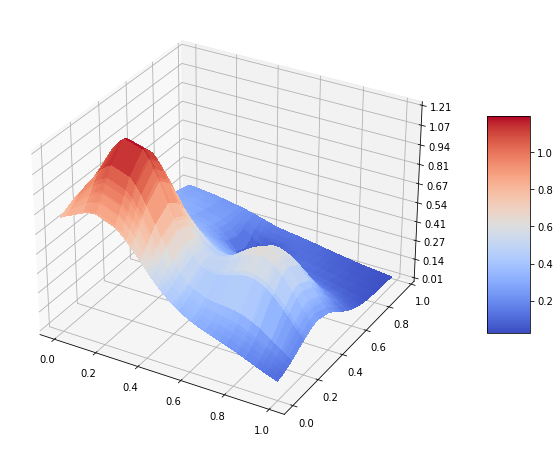

In [2]:
np.random.seed(12)

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

# Make data.
x = np.sort(np.random.uniform(0,1,50))
y = np.sort(np.random.uniform(0,1,50))
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4



z = FrankeFunction(x, y)


# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


# Customize the z axis.
# ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.savefig("Figures/Franke.png")
plt.show()

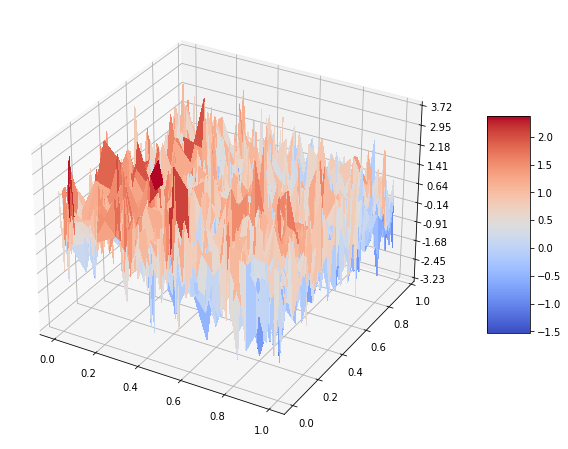

In [3]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

z2 = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))

surf = ax.plot_surface(x, y, z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
# ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.savefig("Figures/FrankeNoise.png")
plt.show()

## Functions and classes used in this project

In [4]:
def create_X(x, y, n ):
        if len(x.shape) > 1:
                x = np.ravel(x)
                y = np.ravel(y)

        N = len(x)
        l = int((n+1)*(n+2)/2)                                                                        
        X = np.ones((N,l))

        for i in range(1,n+1):
                q = int((i)*(i+1)/2)
                for k in range(i+1):
                        X[:,q+k] = (x**(i-k))*(y**k)
#                         print("X^{}*Y^{}".format(i-k,k))

        return X

def MSE(y,ytilde):

    return sum((y-ytilde)**2) / len(y)

def R2(y,ytilde):
    first = sum((y-ytilde)**2)
    second = sum((y-np.mean(y))**2)
    
    return 1 - first / second
def Bias(y,ytilde):
    return sum((y_test - np.mean(ytilde))**2) / len(y)

def Variance(y,ytilde):
    return np.var(ytilde)

def KFoldSplit(X,n_folds):

    n_folds = n_folds
    lenoffolds = (len(X) / n_folds)
    folds = []
    for i in range(n_folds):
        if i == range(n_folds)[-1]:
            first_ix = int(lenoffolds)*i
            second_ix = int(lenoffolds)*(i+1) 
            if second_ix != len(X):
                second_ix += 1
            else:
                pass
        else:
            first_ix = int(lenoffolds)*i
            second_ix = int(lenoffolds)*(i+1) 
        test_ix = np.arange(first_ix,second_ix)
        train_ix = np.delete(np.arange(0,len(X)),np.arange(first_ix,second_ix))
        folds.append((train_ix,test_ix))
        
    return folds

def to_categorical_numpy(interger_vector):
    n_inputs = len(interger_vector)
    n_categories = np.max(interger_vector) + 1 
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs),interger_vector] = 1 
    
    return onehot_vector

def learning_schedule(t):
    return t0 / (t+t1)

In [5]:

class Layer:
    
    def __init__(self,n_input, n_neurons, activation=None, weights=None, bias=None, lrelu_alpha=0.01):
        
        self.n_neurons = n_neurons
        self.n_input = n_input
        
        self.weights = weights if weights is not None else np.random.randn(self.n_input, self.n_neurons)
        self.activation = activation
        self.bias = bias if bias is not None else np.random.rand(self.n_neurons)
        
        self.lrelu_alpha = lrelu_alpha
        
    def modify_layer(self,n_input=None,n_neurons=None,activation=None,weights=None, bias=None):
       
        self.n_neurons = n_neurons if n_neurons is not None else self.n_neurons
        self.n_input = n_input if n_input is not None else self.n_input
        self.activation = activation if activation is not None else self.n_input
        
        self.weights = weights if weights is not None else np.random.randn(self.n_input, self.n_neurons)
        self.activation = activation
        self.bias = bias if bias is not None else np.random.rand(self.n_neurons)
        
    def activate(self, x):
        
        z_h = np.matmul(x, self.weights) + self.bias
        self.z = np.matmul(x, self.weights) + self.bias
        self.last_activation = self._apply_activation(z_h)
        return self.last_activation
    
    def _apply_activation(self,z_h):
        self.z_h = z_h
        if self.activation is None:
            return z_h
        
        if self.activation == "tanh":
            return np.tanh(z_h)
        
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-z_h))
        
        if self.activation == "softmax":
            return np.exp(z_h) / np.sum(np.exp(z_h),axis=1, keepdims=True)
        
        if self.activation == "relu":
            
            return np.maximum(0,z_h)
            
        if self.activation == "leaky_relu":
            fx = z_h.copy()
            fx = np.where(fx<0,self.lrelu_alpha*fx,fx)
            
            return fx
        
        else:
            return self.activation(z_h)
    
    def apply_activation_derivative(self, f):
        import autograd.numpy as np
        from autograd import elementwise_grad as egrad
        
        if self.activation is None:
            return f
        
        if self.activation == "tanh":
            return 1 - f**2 
        
        if self.activation == "sigmoid":
            return f  * (1 - f)
        
        if self.activation == "softmax":
            return f  * (1 - f)
        
        if self.activation == "relu":
            fx = f.copy()
            fx = np.where(fx<=0, 0, 1)

            return fx 
        
        if self.activation == "leaky_relu":
            fx = f.copy()
            fx = np.where(self.z_h<0,self.lrelu_alpha,1)
            return fx
        else:
            return egrad(self.activation)(f) 

class NeuralNetwork:
    
    def __init__(self):
        self._layers = []
        
    def add_layer(self, layer):

        self._layers.append(layer)
        
    def feed_forward(self, X):
        
        for layer in self._layers:
            X = layer.activate(X)
        return X 
    
    def predict(self, X):
        
        output = self.feed_forward(X)

        if output.shape[1]==1:
            return output
        
        if output.ndim == 1: 
            return np.argmax(output)
        
        return np.argmax(output, axis=1)
    
    def backpropagation(self, X, y, eta=0.1, alpha=0):
        
        output = self.feed_forward(X)

        for i in reversed(range(len(self._layers))):
            
            layer = self._layers[i]
            
            if layer == self._layers[-1]:
#                 output = output.reshape(1,-1)
                layer.error = output - y
                layer.delta = layer.error
                
#                 layer.weight_gradient = np.matmul(layer.last_activation.T,layer.delta)
#                 layer.bias_gradient = np.sum(layer.delta, axis=0)
                
            
            else:
                next_layer = self._layers[i+1] 
                
                layer.delta = np.matmul(next_layer.delta,next_layer.weights.T) \
                * layer.apply_activation_derivative(layer.last_activation)
                
#                 layer.weight_gradient = np.matmul(layer.)

        for i in range(len(self._layers)):
            layer = self._layers[i]
            
#             a_l_minus_1 = np.atleast_2d(X if i == 0 else self._layers[i-1].last_activation)
            a_l_minus_1 = (X if i == 0 else self._layers[i-1].last_activation)
            if alpha != 0: 
                layer.weight_gradient += alpha * layer.weights
                
            layer.weight_gradient = np.matmul(a_l_minus_1.T,layer.delta)
            layer.bias_gradient = np.sum(layer.delta)
            
            layer.weights -= layer.weight_gradient * eta
            layer.bias -= layer.bias_gradient * eta
            
    def learning_schedule(t):
        return t0 / (t+t1)
    
    def train(self, X, y, eta=0.1, max_epochs=10,
              batch_size=100,alpha=0,
             t0=1,t1=10,use_learning_schedule="False"):
        
        
        self.iterations = X.shape[0] // batch_size
        
        data_indicies = np.arange(X.shape[0])
        
        for i in range(max_epochs):
                for j in range(self.iterations):
                    
                    chosen_datapoints = np.random.choice( data_indicies, size = batch_size, replace=False )
                    if use_learning_schedule == "True":
                        
                        eta_ = learning_schedule(i * self.iterations + j)
                    else:
                        eta_ = eta
                    X_ = X[chosen_datapoints]
                    y_ = y[chosen_datapoints]
                    
                    self.backpropagation(X_,y_, eta_)            
    

## Part a): Write your own Stochastic Gradient Descent code, first step.

In [6]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)

x, y = np.meshgrid(x,y)

X = create_X(x,y,5)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()
print("X shape:{}\nz shape:{}".format(X.shape,z.shape))

X_train,X_test, y_train,y_test = train_test_split(X,z,test_size=0.2)

X shape:(100, 21)
z shape:(100,)


In [7]:
warnings.filterwarnings('ignore') 
np.random.seed(12)


max_epochs = 100
n = X.shape[0] 
batch_size = 10

iterations = n //batch_size


t0, t1 = 1,5 

lmb_vals = np.linspace(0.1,1,7)
lmb_vals = np.insert(lmb_vals,0,0)
eta_vals = np.logspace(-5,-0.02,10)

results = []

beta_ols = np.random.randn(X_train.shape[1])
beta_ridge = np.random.randn(X_train.shape[1])

for eta in tqdm( eta_vals):
    lmb_results = []
    for lmb in lmb_vals:
        np.random.seed(12)
        for epoch in (range(max_epochs)):
            np.random.seed(12)
            for i in range(iterations):
                np.random.seed(12)
                random_index = np.random.randint(iterations)
                
                xi = X_train[random_index:random_index+1]
                yi = y_train[random_index:random_index+1]

                gradients_ols = 2 * xi.T@((xi@beta_ols) - yi)
                gradients_ridge = 2.0/n  * xi.T @ (xi@(beta_ridge) - yi) + 2*lmb*beta_ridge


#                 eta = learning_schedule(epoch * iterations + i)
#                 print(eta)
                beta_ols = beta_ols - eta*gradients_ols
                beta_ridge = beta_ridge - eta*gradients_ridge

        ytilde_ols = X_test @ beta_ols
        ytilde_ridge = X_test @ beta_ridge

        sgdreg = SGDRegressor(loss='squared_loss',max_iter=iterations,tol=1e-3,penalty="l2",eta0=eta,alpha=lmb)
        sgdreg.fit(X_train,y_train)
        ytilde_sgdreg = sgdreg.predict(X_test)

        mse_ols = mean_squared_error(y_test,ytilde_ols)
        mse_ridge = mean_squared_error(y_test,ytilde_ridge)
        mse_sgdreg = mean_squared_error(y_test,ytilde_sgdreg)

        lmb_results.append((mse_ols,mse_ridge,mse_sgdreg))
    results.append(lmb_results)
results_df = pd.concat([pd.DataFrame(df,index=[lmb_vals],columns=["OLS","Ridge","Sklearn SGDReg"]).rename_axis("Lambdas") for df in results], axis=1, keys=eta_vals).rename_axis(["Learning rate","Model"],axis=1)

In [8]:
OLS = results_df.loc[0,pd.IndexSlice[:,"OLS"]]
OLS = OLS.droplevel(1,1)
OLS.columns = OLS.columns.values.round(5)
OLS = OLS.rename_axis("Learning rate",axis=1).round(2)
dfi.export(OLS,"Tex/Figures/OLSSGD.png")
OLS

Learning rate,0.00001,0.00004,0.00013,0.00046,0.00163,0.00584,0.02089,0.07470,0.26710,0.95499
Lambdas,,,,,,,,,,
0.0,29.4,27.52,27.15,27.15,27.15,27.15,27.15,27.15,27.15,27.15


In [9]:
Ridge = results_df.loc[:,pd.IndexSlice[:,"Ridge"]]
Ridge.round(4)

Learning rate,0.000010,0.000036,0.000128,0.000457,0.001634,0.005843,0.020893,0.074702,0.267096,0.954993
Model,Ridge,Ridge,Ridge,Ridge,Ridge,Ridge,Ridge,Ridge,Ridge,Ridge
Lambdas,,,,,,,,,,
0.00,68.7465,57.5071,30.5494,3.8665,0.9081,1.1473,1.5890,1.6431,1.6431,1.643100e+00
0.10,68.3161,56.2400,28.2886,3.2139,0.9377,1.0000,0.9841,0.9839,0.9839,9.839000e-01
0.25,67.4801,53.8292,24.2802,2.2263,0.8999,0.8886,0.8872,0.8872,0.8872,8.872000e-01
0.40,66.2534,50.4257,19.3361,1.4368,0.8743,0.8707,0.8707,0.8707,0.8707,8.707000e-01
0.55,64.6579,46.2345,14.3165,1.0246,0.8669,0.8663,0.8663,0.8663,0.8663,8.663000e-01
0.70,62.7216,41.4941,9.8955,0.8816,0.8652,0.8651,0.8651,0.8651,0.8651,8.651000e-01
0.85,60.4779,36.4547,6.4394,0.8542,0.8650,0.8650,0.8650,0.8650,0.8650,8.650000e-01
1.00,57.9644,31.3565,4.0145,0.8568,0.8652,0.8652,0.8652,0.8652,0.8652,2.246308e+49


In [10]:
Sklearn = results_df.loc[:,pd.IndexSlice[:,"Sklearn SGDReg"]]
dfi.export(Sklearn.droplevel(1,axis=1).round(2),"Tex/Figures/Sklearn SGDReg.png",fontsize=12)
Sklearn

Learning rate,0.000010,0.000036,0.000128,0.000457,0.001634,0.005843,0.020893,0.074702,0.267096,0.954993
Model,Sklearn SGDReg,Sklearn SGDReg,Sklearn SGDReg,Sklearn SGDReg,Sklearn SGDReg,Sklearn SGDReg,Sklearn SGDReg,Sklearn SGDReg,Sklearn SGDReg,Sklearn SGDReg
Lambdas,,,,,,,,,,
0.00,0.870372,0.862905,0.848064,0.841876,0.865735,0.916574,1.040557,1.326434,9.633042e+20,6.010167e+23
0.10,0.870372,0.862908,0.848082,0.841813,0.865009,0.913575,1.035460,1.326448,1.068004e+21,1.808079e+24
0.25,0.870372,0.862913,0.848110,0.841721,0.863961,0.909634,1.030611,1.325995,2.707213e+18,1.838078e+24
0.40,0.870373,0.862917,0.848138,0.841632,0.862962,0.906253,1.027286,1.318923,2.432678e+15,2.010957e+23
0.55,0.870373,0.862922,0.848166,0.841547,0.862008,0.903330,1.024550,1.307099,1.021571e+11,9.173043e+22
0.70,0.870373,0.862926,0.848194,0.841464,0.861098,0.900784,1.022014,1.292459,2.389809e+10,6.642750e+22
0.85,0.870373,0.862930,0.848222,0.841385,0.860229,0.898551,1.019523,1.276265,7.235788e+03,5.320459e+22
1.00,0.870373,0.862935,0.848250,0.841309,0.859399,0.896577,1.017021,1.259299,5.077584e+01,4.489526e+23


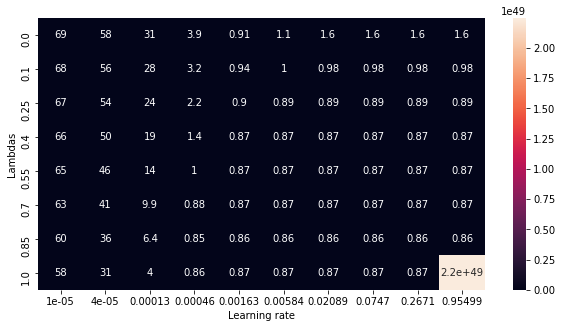

In [11]:
plt.figure(figsize=(10,5))
sns.heatmap(Ridge.droplevel(1,axis=1),
            xticklabels=Ridge.columns.levels[0].values.round(5),
           yticklabels=Ridge.index.levels[0].values.round(5),
           annot=True)
plt.savefig("Tex/Figures/SGD Ridge.png")

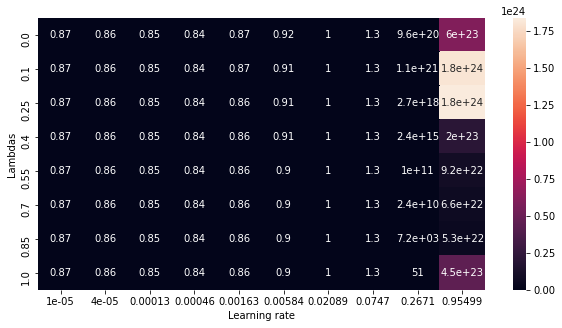

In [12]:
plt.figure(figsize=(10,5))
sns.heatmap(Sklearn.droplevel(1,axis=1),
            xticklabels=Sklearn.columns.levels[0].values.round(5),
           yticklabels=Sklearn.index.levels[0].values.round(5),
           annot=True)
plt.savefig("Tex/Figures/SGD Sklearn OLS.png")

## Part b): Writing your own Neural Network code.

### Neural Network

In [13]:

class Layer:
    
    def __init__(self,n_input, n_neurons, activation=None, weights=None, bias=None, lrelu_alpha=0.01):
        
        self.n_neurons = n_neurons
        self.n_input = n_input
        
        self.weights = weights if weights is not None else np.random.randn(self.n_input, self.n_neurons)
        self.activation = activation
        self.bias = bias if bias is not None else np.random.rand(self.n_neurons)
        
        self.lrelu_alpha = lrelu_alpha
        
    def modify_layer(self,n_input=None,n_neurons=None,activation=None,weights=None, bias=None):
       
        self.n_neurons = n_neurons if n_neurons is not None else self.n_neurons
        self.n_input = n_input if n_input is not None else self.n_input
        self.activation = activation if activation is not None else self.n_input
        
        self.weights = weights if weights is not None else np.random.randn(self.n_input, self.n_neurons)
        self.activation = activation
        self.bias = bias if bias is not None else np.random.rand(self.n_neurons)
        
    def activate(self, x):
        
        z_h = np.matmul(x, self.weights) + self.bias
        self.z = np.matmul(x, self.weights) + self.bias
        self.last_activation = self._apply_activation(z_h)
        return self.last_activation
    
    def _apply_activation(self,z_h):
        self.z_h = z_h
        if self.activation is None:
            return z_h
        
        if self.activation == "tanh":
            return np.tanh(z_h)
        
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-z_h))
        
        if self.activation == "softmax":
            return np.exp(z_h) / np.sum(np.exp(z_h),axis=1, keepdims=True)
        
        if self.activation == "relu":
            
            return np.maximum(0,z_h)
            
        if self.activation == "leaky_relu":
            fx = z_h.copy()
            fx = np.where(fx<0,self.lrelu_alpha*fx,fx)
            
            return fx
        
        else:
            return self.activation(z_h)
    
    def apply_activation_derivative(self, f):
        import autograd.numpy as np
        from autograd import elementwise_grad as egrad
        
        if self.activation is None:
            return f
        
        if self.activation == "tanh":
            return 1 - f**2 
        
        if self.activation == "sigmoid":
            return f  * (1 - f)
        
        if self.activation == "softmax":
            return f  * (1 - f)
        
        if self.activation == "relu":
            fx = f.copy()
            fx = np.where(fx<=0, 0, 1)

            return fx 
        
        if self.activation == "leaky_relu":
            fx = f.copy()
            fx = np.where(self.z_h<0,self.lrelu_alpha,1)
            return fx
        else:
            return egrad(self.activation)(f) 

class NeuralNetwork:
    
    def __init__(self):
        self._layers = []
        
    def add_layer(self, layer):

        self._layers.append(layer)
        
    def feed_forward(self, X):
        
        for layer in self._layers:
            X = layer.activate(X)
        return X 
    
    def predict(self, X):
        
        output = self.feed_forward(X)

        if output.shape[1]==1:
            return output
        
        if output.ndim == 1: 
            return np.argmax(output)
        
        return np.argmax(output, axis=1)
    
    def backpropagation(self, X, y, eta=0.1, alpha=0):
        
        output = self.feed_forward(X)

        for i in reversed(range(len(self._layers))):
            
            layer = self._layers[i]
            
            if layer == self._layers[-1]:
#                 output = output.reshape(1,-1)
                layer.error = output - y
                layer.delta = layer.error
                
#                 layer.weight_gradient = np.matmul(layer.last_activation.T,layer.delta)
#                 layer.bias_gradient = np.sum(layer.delta, axis=0)
                
            
            else:
                next_layer = self._layers[i+1] 
                
                layer.delta = np.matmul(next_layer.delta,next_layer.weights.T) \
                * layer.apply_activation_derivative(layer.last_activation)
                
#                 layer.weight_gradient = np.matmul(layer.)

        for i in range(len(self._layers)):
            layer = self._layers[i]
            
#             a_l_minus_1 = np.atleast_2d(X if i == 0 else self._layers[i-1].last_activation)
            a_l_minus_1 = (X if i == 0 else self._layers[i-1].last_activation)
            if alpha != 0: 
                layer.weight_gradient += alpha * layer.weights
                
            layer.weight_gradient = np.matmul(a_l_minus_1.T,layer.delta)
            layer.bias_gradient = np.sum(layer.delta)
            
            layer.weights -= layer.weight_gradient * eta
            layer.bias -= layer.bias_gradient * eta
            
    def learning_schedule(t):
        return t0 / (t+t1)
    
    def train(self, X, y, eta=0.1, max_epochs=10,
              batch_size=100,alpha=0,
             t0=1,t1=10,use_learning_schedule="False"):
        
        
        self.iterations = X.shape[0] // batch_size
        
        data_indicies = np.arange(X.shape[0])
        
        for i in range(max_epochs):
                for j in range(self.iterations):
                    
                    chosen_datapoints = np.random.choice( data_indicies, size = batch_size, replace=False )
                    if use_learning_schedule == "True":
                        
                        eta_ = learning_schedule(i * self.iterations + j)
                    else:
                        eta_ = eta
                    X_ = X[chosen_datapoints]
                    y_ = y[chosen_datapoints]
                    
                    self.backpropagation(X_,y_, eta_)            
    

### Franke function

In [14]:
np.random.seed(12)
x = np.random.uniform(0,1,10)
y = np.random.uniform(0,1,10)

x, y = np.meshgrid(x,y)

X = create_X(x,y,5)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
z = z.ravel()
print("X shape:{}\nz shape:{}".format(X.shape,z.shape))

X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.2)
y_train=y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

X shape:(100, 21)
z shape:(100,)


In [15]:
warnings.filterwarnings('ignore')
np.random.seed(12)

Polynomial_degree = 21
n_bootstraps = 50
lmb = 0
epochs = 50
results = []
eta_vals = np.linspace(1e-5,2e-1,10)

for N in trange(Polynomial_degree):
    
    X = create_X(x,y,N)
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X[:,0] = 1
    
    I = np.eye(len(X.T),len(X.T))
    
    z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
    z = z.ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.2)
    y_train=y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    
    results_eta = []
    for eta in eta_vals:
    
        Predictions_ols = np.zeros((len(X_test),n_bootstraps))
        Predictions_ridge = np.zeros((len(X_test),n_bootstraps))
        Predictions_nn = np.zeros((len(X_test),n_bootstraps))
        Predictions_sk_nn = np.zeros((len(X_test),n_bootstraps))

        for i in range(n_bootstraps):
            x_train_rs, y_train_rs = resample(X_train,y_train)

            beta_ols = np.linalg.inv(x_train_rs.T @ x_train_rs) @ (x_train_rs.T @ y_train_rs)
            ytilde_ols =  X_test @ beta_ols
            Predictions_ols[:,i] = ytilde_ols.ravel()

            nn = NeuralNetwork()
            nn.add_layer(Layer(x_train_rs.shape[1],50,"sigmoid"))
            nn.add_layer(Layer(50,1))
            nn.train(x_train_rs,y_train_rs,eta=eta,alpha=lmb)
            ytilde_nn = nn.predict(X_test)
            Predictions_nn[:,i] = ytilde_nn.ravel()

            sk_nn = MLPRegressor( hidden_layer_sizes=50, activation="logistic",alpha=lmb,
                        learning_rate_init=eta,max_iter=epochs)
            sk_nn.fit(x_train_rs,y_train_rs.ravel())
            ytilde_sk_nn = sk_nn.predict(X_test)
            Predictions_sk_nn[:,i] = ytilde_sk_nn.ravel()


        mse_ols = np.mean(np.mean((y_test - Predictions_ols)**2,axis=1, keepdims=True))
        mse_nn = np.mean(np.mean((y_test - Predictions_nn)**2,axis=1, keepdims=True))
        mse_sk_nn = np.mean(np.mean((y_test - Predictions_sk_nn)**2,axis=1, keepdims=True))

        results_eta.append((mse_ols,mse_nn,mse_sk_nn))
    results.append(results_eta)

In [16]:
results_df_1 = pd.concat([pd.DataFrame(df,columns=["OLS","FFNN","Sklearn NN"],index=eta_vals) for df in results],axis=1,keys=range(Polynomial_degree)).\
            rename_axis(["PolyDegree","Model"],axis=1).rename_axis("Learning rate",axis=0)

In [20]:
result_table_1 = results_df_1.loc[:,results_df_1.columns.levels[0][::5]]
dfi.export(result_table_1.round(3),"Tex/Figures/Partb-1.png")
result_table_1.round(4)

PolyDegree         0                           5                       \
Model             OLS     FFNN Sklearn NN     OLS     FFNN Sklearn NN   
Learning rate                                                           
0.000010       1.9490  25.5976     2.0974  1.3271  26.8451     0.7417   
0.022231       1.9596  20.8774     1.9739  1.4925  22.7536     0.4995   
0.044452       1.9481  29.7983     1.9578  1.3699  19.0704     0.5027   
0.066673       1.9543  27.6611     2.0227  1.2635  23.1877     0.5772   
0.088894       1.9499  21.1687     2.2003  1.5178  24.5343     0.6047   
0.111116       1.9585  16.8780     2.4347  1.4599  18.6166     0.6311   
0.133337       1.9511  14.3066     2.0401  1.9593  26.6599     0.7386   
0.155558       1.9602  26.7266     2.1255  1.4964  21.5646     0.9464   
0.177779       1.9551  24.4695     2.1308  1.1286  21.7536     1.0437   
0.200000       1.9550  24.9607     2.1611  2.2544  23.4604     0.9300   

PolyDegree               10                                15           \
Model                   OLS     FFNN Sklearn NN           OLS     FFNN   
Learning rate                                                            
0.000010       3.050681e+06  19.7160     1.1147  1.685535e+08  28.1218   
0.022231       5.525115e+06  25.9546     1.0520  6.344885e+09  29.0732   
0.044452       4.882060e+07  21.1121     1.1431  1.837031e+09  25.3683   
0.066673       1.112662e+07  24.1660     1.1162  3.288897e+10  25.4682   
0.088894       1.175800e+07  21.4102     1.1536  6.725222e+09  21.7729   
0.111116       8.350315e+07  23.4501     1.3098  2.403175e+09  24.8635   
0.133337       3.634190e+07  21.1374     1.2952  1.928201e+08  24.3632   
0.155558       1.632347e+09  19.3221     1.2639  6.370862e+08  29.4553   
0.177779       7.834854e+05  24.3894     1.2815  1.849033e+10  25.2381   
0.200000       2.953103e+06  27.8661     1.4490  3.592577e+09  22.9582   

PolyDegree                          20                      
Model         Sklearn NN           OLS     FFNN Sklearn NN  
Learning rate                                               
0.000010          1.5521  2.508132e+09  22.3899     1.1583  
0.022231          1.5095  4.330268e+09  25.1651     1.2023  
0.044452          1.7078  9.248600e+10  24.9510     1.2651  
0.066673          1.6230  1.408236e+12  24.8107     1.2273  
0.088894          1.4837  1.383304e+10  26.1786     1.2431  
0.111116          1.5038  1.248911e+10  26.8911     1.3048  
0.133337          1.6063  4.725656e+11  28.3507     2.0029  
0.155558          1.9176  4.398385e+10  26.6200     1.6854  
0.177779          2.0155  1.425143e+09  28.5620     2.8781  
0.200000          2.2632  1.037413e+09  24.2326     2.9717

<AxesSubplot:xlabel='PolyDegree'>

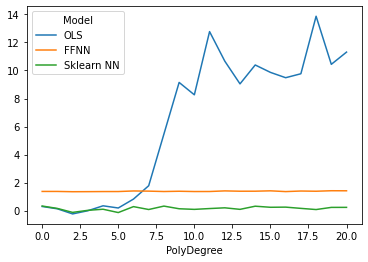

In [21]:
results_df_1.mean(0).unstack(1).apply(lambda x: np.log10(x)).plot()

<AxesSubplot:xlabel='Learning rate'>

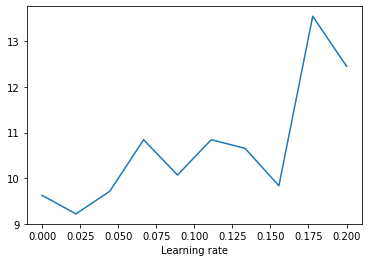

In [22]:
results_df_1.mean(1,level=1)["OLS"].apply(lambda x: np.log10(x)).plot()

<AxesSubplot:xlabel='Learning rate'>

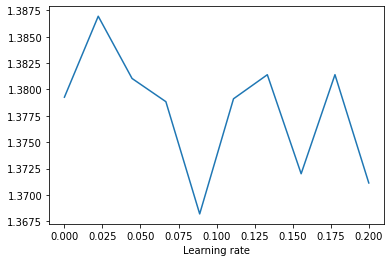

In [23]:
results_df_1.mean(1,level=1)["FFNN"].apply(lambda x: np.log10(x)).plot()

<AxesSubplot:xlabel='Learning rate'>

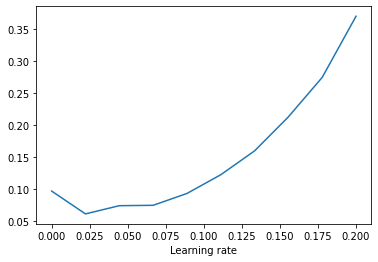

In [24]:
results_df_1.mean(1,level=1)["Sklearn NN"].apply(lambda x: np.log10(x)).plot()

<AxesSubplot:xlabel='Learning rate'>

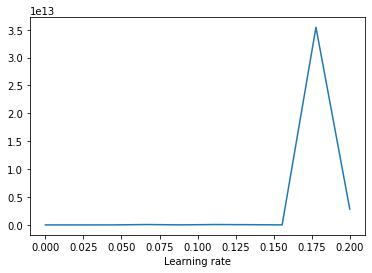

In [25]:
results_df_1.loc[:,pd.IndexSlice[:,"OLS"]].mean(1).plot()

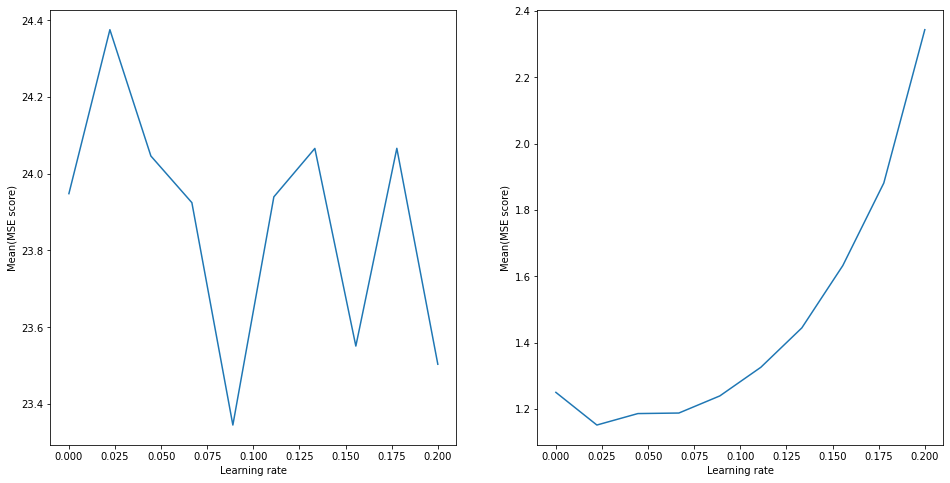

In [26]:
fig,ax = plt.subplots(1,2)
results_df_1.loc[:,pd.IndexSlice[:,"FFNN"]].mean(1).plot(ax=ax[0],figsize=(16,8))
ax[0].set_ylabel("Mean(MSE score)")
ax[1].set_ylabel("Mean(MSE score)")
results_df_1.loc[:,pd.IndexSlice[:,"Sklearn NN"]].mean(1).plot(ax=ax[1])
plt.savefig("Tex/Figures/Partb-2.png")

<AxesSubplot:xlabel='Learning rate'>

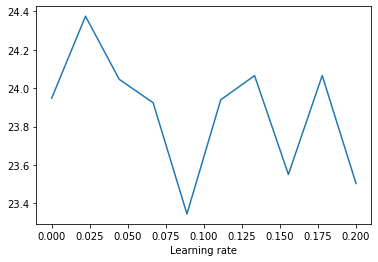

In [27]:
results_df_1.loc[:,pd.IndexSlice[:,"FFNN"]].mean(1).plot()

<AxesSubplot:xlabel='Learning rate'>

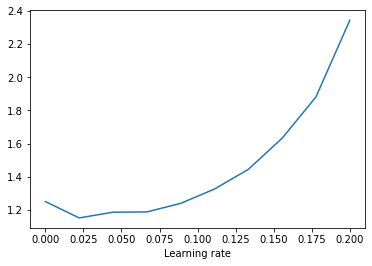

In [28]:
results_df_1.loc[:,pd.IndexSlice[:,"Sklearn NN"]].mean(1).plot()

In [29]:
np.random.seed(12)

Polynomial_degree = 20
n_bootstraps = 50
eta = 0.1
lmb_vals = np.logspace(-2,1,10)
lmb_vals = np.insert(lmb_vals,0,0)
epochs = 50
results = []

for lmb in tqdm(lmb_vals):
    lmb_results = []
    for N in range(Polynomial_degree):
        np.random.seed(12)
        X = create_X(x,y,N)
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        X[:,0] = 1

        I = np.eye(len(X.T),len(X.T))

        z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
        z = z.ravel()

        X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.2)
        y_train=y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)



        Predictions_ols = np.zeros((len(X_test),n_bootstraps))
        Predictions_ridge = np.zeros((len(X_test),n_bootstraps))
        Predictions_nn = np.zeros((len(X_test),n_bootstraps))
        Predictions_sk_nn = np.zeros((len(X_test),n_bootstraps))

        for i in range(n_bootstraps):
            x_train_rs, y_train_rs = resample(X_train,y_train)

            beta_ols = np.linalg.inv(x_train_rs.T @ x_train_rs) @ (x_train_rs.T @ y_train_rs)
            ytilde_ols =  X_test @ beta_ols
            Predictions_ols[:,i] = ytilde_ols.ravel()

            beta_ridge = np.linalg.inv(x_train_rs.T@x_train_rs +lmb*I) @ x_train_rs.T@y_train_rs
            ytilde_ridge =  X_test @ beta_ridge
            Predictions_ridge[:,i] = ytilde_ridge.ravel()

            nn = NeuralNetwork()
            nn.add_layer(Layer(x_train_rs.shape[1],50,"sigmoid"))
            nn.add_layer(Layer(50,1))
            nn.train(x_train_rs,y_train_rs,eta=eta,alpha=lmb)
            ytilde_nn = nn.predict(X_test)
            Predictions_nn[:,i] = ytilde_nn.ravel()

            sk_nn = MLPRegressor( hidden_layer_sizes=50, activation="logistic",alpha=lmb,
                        learning_rate_init=eta,max_iter=epochs)
            sk_nn.fit(x_train_rs,y_train_rs.ravel())
            ytilde_sk_nn = sk_nn.predict(X_test)
            Predictions_sk_nn[:,i] = ytilde_sk_nn.ravel()


        mse_ols = np.mean(np.mean((y_test - Predictions_ols)**2,axis=1, keepdims=True))
        mse_ridge = np.mean(np.mean((y_test - Predictions_ridge)**2,axis=1, keepdims=True))
        mse_nn = np.mean(np.mean((y_test - Predictions_nn)**2,axis=1, keepdims=True))
        mse_sk_nn = np.mean(np.mean((y_test - Predictions_sk_nn)**2,axis=1, keepdims=True))

        lmb_results.append((mse_ols,mse_ridge,mse_nn,mse_sk_nn))
    results.append(lmb_results)

In [30]:
results_df_2= pd.concat([pd.DataFrame(df,columns=["OLS","Ridge","FFNN","Sklearn NN"],index=range(Polynomial_degree)) for df in results],axis=1,keys=(lmb_vals))
results_df_2 = results_df_2.rename_axis("PolyDegree",axis=0).rename_axis(["Lambda","Model"],axis=1)

<AxesSubplot:xlabel='PolyDegree'>

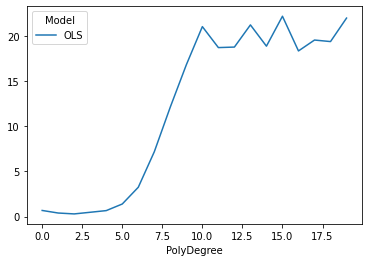

In [31]:
OLS = results_df_2.loc[:,pd.IndexSlice[:,"OLS"]].loc[:,0]
OLS.round(4).apply(lambda x: np.log(x)).plot()

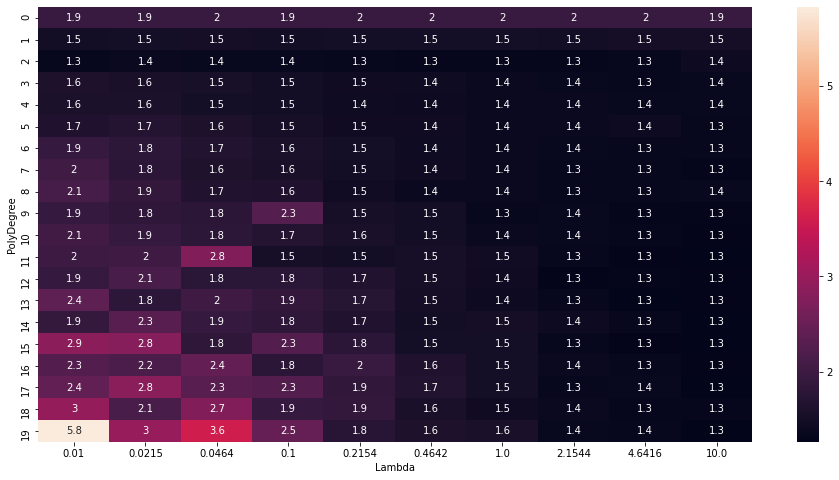

In [34]:
Ridge = results_df_2.loc[:,pd.IndexSlice[:,"Ridge"]].loc[:,0.01:]
plt.figure(figsize=(16,8))
sns.heatmap(Ridge.droplevel(1,1),annot=True,
           xticklabels=Ridge.columns.levels[0].drop(0).values.round(4))
plt.savefig("Tex/Figures/Partb-3.png")

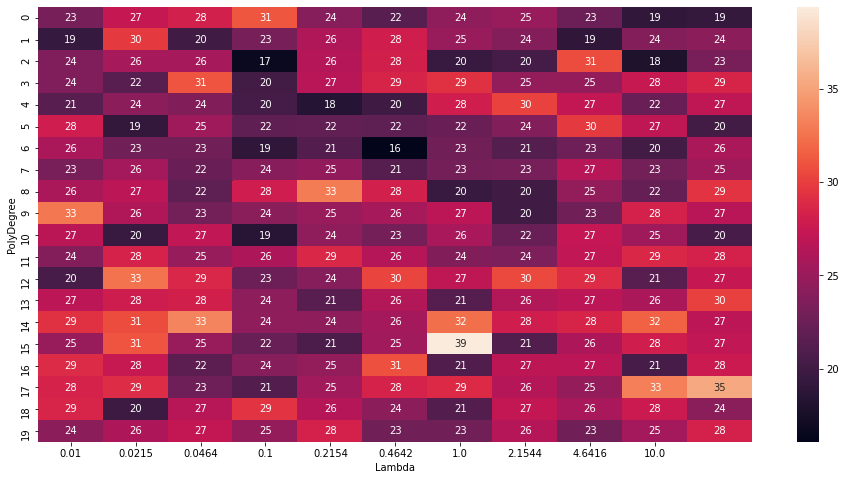

In [35]:
FFNN = results_df_2.loc[:,pd.IndexSlice[:,"FFNN"]]
plt.figure(figsize=(16,8))
sns.heatmap(FFNN.droplevel(1,1),annot=True,
           xticklabels=FFNN.columns.levels[0].drop(0).values.round(4))
plt.savefig("Tex/Figures/Partb-4.png")

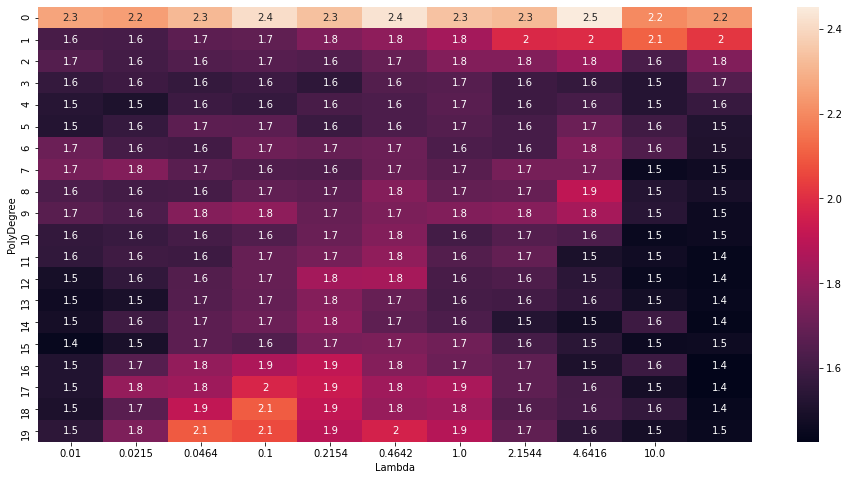

In [36]:
FFNN = results_df_2.loc[:,pd.IndexSlice[:,"Sklearn NN"]]
plt.figure(figsize=(16,8))
sns.heatmap(FFNN.droplevel(1,1),annot=True,
           xticklabels=FFNN.columns.levels[0].drop(0).values.round(4))
plt.savefig("Tex/Figures/Partb-5.png")

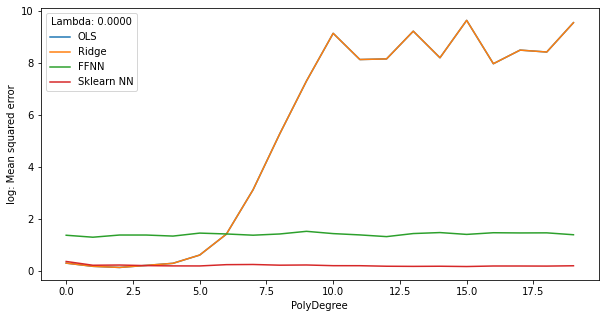

In [37]:
results_df_2.loc[:,pd.IndexSlice[lmb_vals[0],:]].droplevel(0,axis=1).apply(lambda x: np.log10(x)).plot(figsize=(10,5))
plt.ylabel("log: Mean squared error")
plt.legend(title="Lambda: {:.4f}".format(lmb_vals[0]))
plt.savefig("Tex/Figures/NNReg1.png")

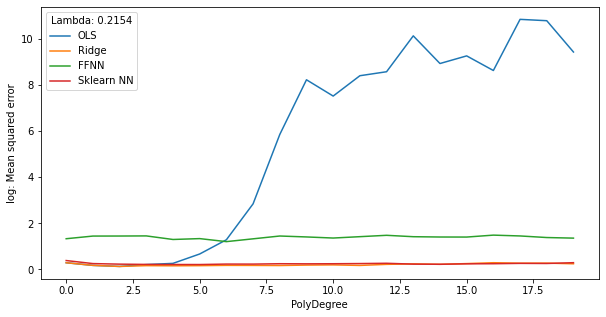

In [38]:
results_df_2.loc[:,pd.IndexSlice[lmb_vals[5],:]].droplevel(0,axis=1).apply(lambda x: np.log10(x)).plot(figsize=(10,5))
plt.ylabel("log: Mean squared error")
plt.legend(title="Lambda: {:.4f}".format(lmb_vals[5]))
plt.savefig("Tex/Figures/NNReg2.png")

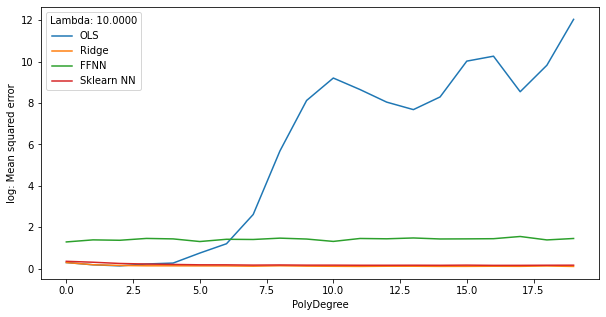

In [39]:
results_df_2.loc[:,pd.IndexSlice[lmb_vals[-1],:]].droplevel(0,axis=1).apply(lambda x: np.log10(x)).plot(figsize=(10,5))
plt.ylabel("log: Mean squared error")
plt.legend(title="Lambda: {:.4f}".format(lmb_vals[-1]))
plt.savefig("Tex/Figures/NNReg3.png")

## Part c): Testing different activation functions.

In [40]:
np.random.seed(12)

Polynomial_degree = 20
n_bootstraps = 50
eta = 0.1
lmb_vals = np.logspace(-2,1,10)
lmb_vals = np.insert(lmb_vals,0,0)
epochs = 50
results = []

for lmb in tqdm(lmb_vals):
    lmb_results = []
    for N in range(Polynomial_degree):
        np.random.seed(12)
        X = create_X(x,y,N)
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        X[:,0] = 1

        I = np.eye(len(X.T),len(X.T))

        z = FrankeFunction(x, y) + np.random.normal(0,1,(len(x),len(y)))
        z = z.ravel()

        X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.2)
        y_train=y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)

        Predictions_nn_relu = np.zeros((len(X_test),n_bootstraps))
        Predictions_sk_nn_relu = np.zeros((len(X_test),n_bootstraps))
        Predictions_nn_Lrelu = np.zeros((len(X_test),n_bootstraps))
        
        for i in range(n_bootstraps):
            x_train_rs, y_train_rs = resample(X_train,y_train)

            nn = NeuralNetwork()
            nn.add_layer(Layer(x_train_rs.shape[1],50,"relu"))
            nn.add_layer(Layer(50,1))
            nn.train(x_train_rs,y_train_rs,eta=eta,alpha=lmb)
            ytilde_nn_relu = nn.predict(X_test)
            Predictions_nn_relu[:,i] = ytilde_nn_relu.ravel()
            
            nn = NeuralNetwork()
            nn.add_layer(Layer(x_train_rs.shape[1],50,"leaky_relu"))
            nn.add_layer(Layer(50,1))
            nn.train(x_train_rs,y_train_rs,eta=eta,alpha=lmb)
            ytilde_nn_lrelu = nn.predict(X_test)
            Predictions_nn_Lrelu[:,i] = ytilde_nn_lrelu.ravel()
            
            sk_nn = MLPRegressor( hidden_layer_sizes=50, activation="relu",alpha=lmb,
                        learning_rate_init=eta,max_iter=epochs)
            sk_nn.fit(x_train_rs,y_train_rs.ravel())
            ytilde_sk_nn = sk_nn.predict(X_test)
            Predictions_sk_nn_relu[:,i] = ytilde_sk_nn.ravel()


        mse_nn_relu = np.mean(np.mean((y_test - Predictions_nn_relu)**2,axis=1, keepdims=True))
        mse_nn_Lrelu = np.mean(np.mean((y_test - Predictions_nn_Lrelu)**2,axis=1, keepdims=True))
        
        mse_sk_nn_relu = np.mean(np.mean((y_test - Predictions_sk_nn_relu)**2,axis=1, keepdims=True))

        lmb_results.append((mse_nn_relu,mse_nn_Lrelu,mse_sk_nn_relu))
    results.append(lmb_results)

In [41]:
results_df_3= pd.concat([pd.DataFrame(df,columns=["FFNN-Relu","FNN-LRelu","Sklearn NN-Relu"],index=range(Polynomial_degree)) for df in results],axis=1,keys=(lmb_vals))
results_df_3 = results_df_3.rename_axis("PolyDegree",axis=0).rename_axis(["Lambda","Model"],axis=1)

In [42]:
results_df_3[0]
dfi.export(results_df_3[0].round(3),"Tex/Figures/Partc-2.png")

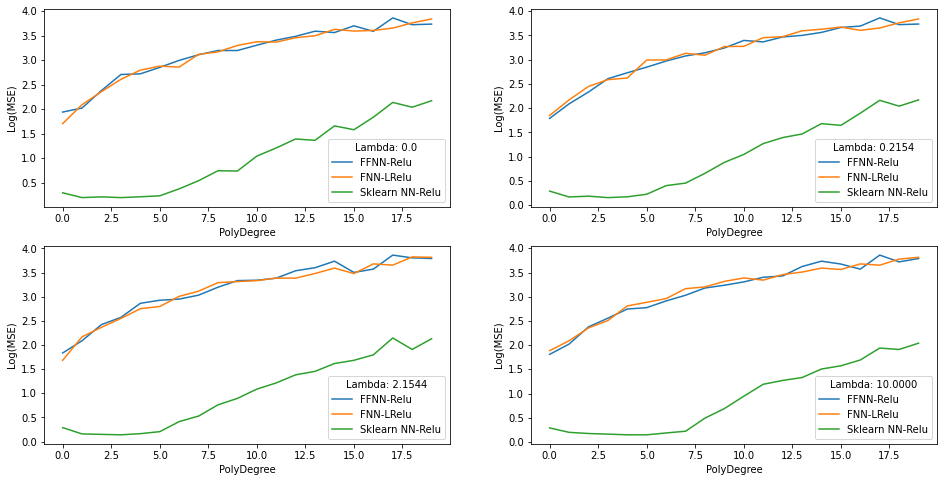

In [43]:
fig, ax = plt.subplots(2,2)
lambdas = results_df_3.columns.levels[0]
results_df_3[lambdas[0]].apply(lambda x: np.log10(x)).plot(ax=ax[0][0],figsize=(16,8))
ax[0][0].legend(title="Lambda: {}".format(lambdas[0]))
ax[0][0].set_ylabel("Log(MSE)")
results_df_3[lambdas[5]].apply(lambda x: np.log10(x)).plot(ax=ax[0][1],figsize=(16,8))
ax[0][1].legend(title="Lambda: {:.4f}".format(lambdas[5]))
ax[0][1].set_ylabel("Log(MSE)")
results_df_3[lambdas[8]].apply(lambda x: np.log10(x)).plot(ax=ax[1][0],figsize=(16,8))
ax[1][0].legend(title="Lambda: {:.4f}".format(lambdas[8]))
ax[1][0].set_ylabel("Log(MSE)")
results_df_3[lambdas[-1]].apply(lambda x: np.log10(x)).plot(ax=ax[1][1],figsize=(16,8))
ax[1][1].legend(title="Lambda: {:.4f}".format(lambdas[-1]))
ax[1][1].set_ylabel("Log(MSE)")
plt.savefig("Tex/Figures/Partc-1.png")

In [44]:
results_df_3.loc[:,pd.IndexSlice[:,"FFNN-Relu"]]

Lambda,0.000000,0.010000,0.021544,0.046416,0.100000,0.215443,0.464159,1.000000,2.154435,4.641589,10.000000
Model,FFNN-Relu,FFNN-Relu,FFNN-Relu,FFNN-Relu,FFNN-Relu,FFNN-Relu,FFNN-Relu,FFNN-Relu,FFNN-Relu,FFNN-Relu,FFNN-Relu
PolyDegree,,,,,,,,,,,
0,86.973080,50.778399,50.013181,63.888376,53.171045,61.609149,42.134819,51.713265,68.411705,63.832211,64.630042
1,105.299958,105.299958,105.299958,122.305907,122.305907,122.848516,122.848516,124.651742,122.848516,105.299958,105.299958
2,239.196216,239.196216,239.196216,239.196216,239.196216,215.300935,251.192791,239.631580,265.258280,239.196216,239.196216
3,508.506998,508.506998,508.506998,446.892490,384.402948,405.329945,383.192765,372.240542,373.160444,379.832258,360.933300
4,524.594656,523.614146,540.311339,573.572394,614.791617,537.579128,519.043037,487.136268,730.943526,551.505660,558.996177
5,710.718612,643.726357,797.891323,673.671554,659.999362,702.335766,781.037385,659.410173,844.347007,943.957971,597.018258
6,987.200333,893.664326,772.474807,1125.842718,1223.905845,938.073490,927.377115,996.848679,893.330704,922.861316,821.553299
7,1286.737809,1348.619082,1094.587414,1472.429281,1079.159400,1193.845000,962.765367,1122.524270,1077.067663,1154.163660,1075.740056
